In [1]:
import os
import sys
sys.path.append('../')
from data import COCODetection, get_label_map, MEANS, COLORS
from yolact import Yolact
from utils.augmentations import BaseTransform, FastBaseTransform, Resize
from utils.functions import MovingAverage, ProgressBar
from layers.box_utils import jaccard, center_size, mask_iou
from utils import timer
from utils.functions import SavePath
from layers.output_utils import postprocess, undo_image_transformation
import pycocotools

from data import cfg, set_cfg, set_dataset

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import argparse
import time
import random
import cProfile
import pickle
import json
import os
from collections import defaultdict
from pathlib import Path
from collections import OrderedDict
from PIL import Image

import matplotlib.pyplot as plt
import cv2

Multiple GPUs detected! Turning off JIT.


### Preprocess the Original Image


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
img = cv2.imread('BFF_ST_000_APT_000_20190513133132.tif')
template = cv2.imread('template.png')

In [5]:
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0] 
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h 
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
    return dets[keep]

In [6]:
def loc_to_dets(loc, m, w, h):
    dets = []
    for pt in zip(*loc[::-1]):
        x1, y1 = pt
        x2, y2 = pt[0] + w, pt[1] + h
        score = m[y1, x1]
        dets.append([x1,y1,x2,y2,score])
    return np.array(dets)

In [7]:
def show_matching(img, template, thres=0.98):
    m = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
    loc = np.where(m>thres)
    img_ = img.copy()
    h, w = template.shape[:2]
    dets = loc_to_dets(loc, m, w, h)
    dets = nms(dets, 0.5)
    print("Find "+str(len(dets))+" markers!")
    for det in dets:
        cv2.rectangle(img_, (int(det[0]), int(det[1])), (int(det[2]), int(det[3])), (0,255,255), 2)
    plt.figure(figsize=(15,15))
    plt.imshow(img_)
    return dets

Find 28 markers!


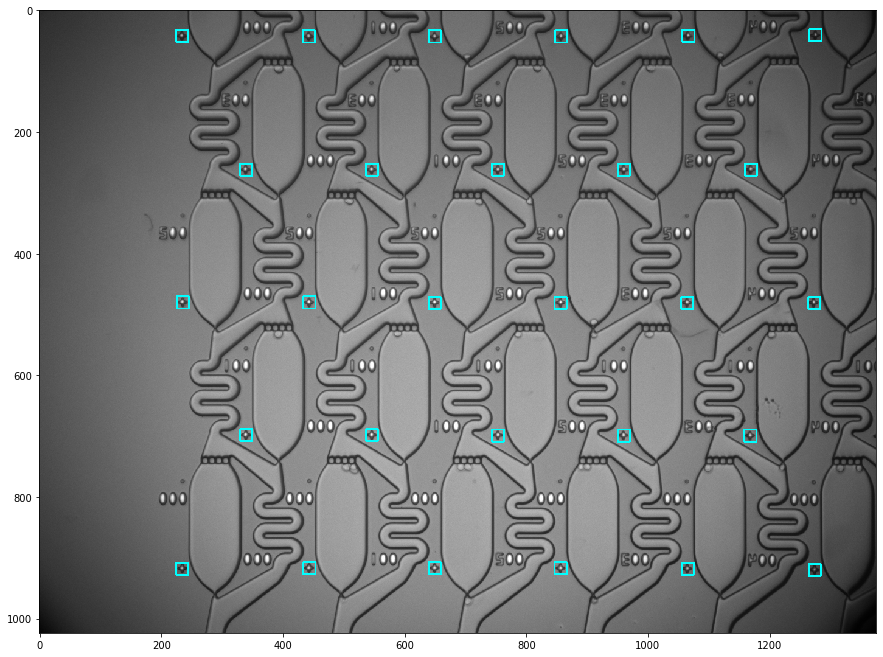

In [8]:
dets = show_matching(img, template)

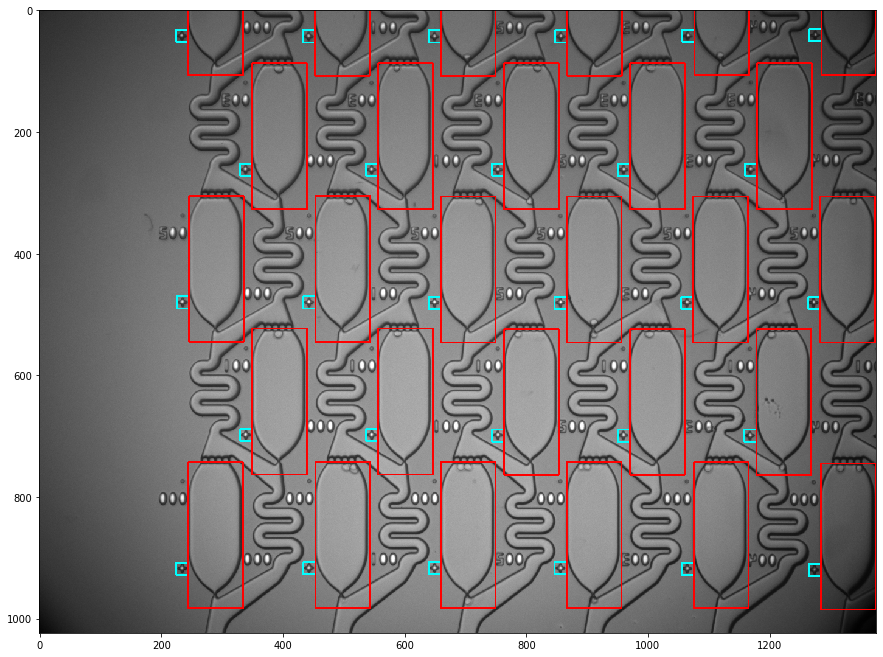

In [93]:
img_ = img.copy()
for det in dets:
    x1, y1, x2, y2 = det[:-1]
    center = (int(x1/2+x2/2), int(y1/2+y2/2))
    cv2.rectangle(img_, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,255), 2)
    cv2.rectangle(img_, (int(center[0]+10), int(center[1]-175)), (int(center[0]+100), int(center[1]+65)), (255,0,0), 2)
plt.figure(figsize=(15,15))
plt.imshow(img_)

In [98]:
def cut_image(img, dets, size): #size=[h, w]
    ans = {'img':[], 'marker':[]}
    h, w = img.shape[:2]
    for det in dets:
        x1, y1, x2, y2 = det[:-1]
        center = (int(x1/2+x2/2), int(y1/2+y2/2))
        xx1, yy1, xx2, yy2 =  int(center[0]+10), int(center[1]-175), int(center[0]+100), int(center[1]+65)
        top, bottom, left, right =0, 0, 0, 0
        if xx1 < 0:
            left = -xx1
            xx1 = 0
        if yy1 < 0:
            top = -yy1
            yy1 = 0
        if xx2 > w:
            right = xx2-w
            xx2 = w
        if yy2 > h:
            bottom = yy2 - h
            yy2 = h
        ans['img'].append(cv2.copyMakeBorder(img[yy1:yy2, xx1:xx2], top, bottom, left, right, cv2.BORDER_CONSTANT, value=0))
        ans['marker'].append(center)
    return ans

In [99]:
imgs = cut_image(img, dets, (240,90))

/home/home1/sy189/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


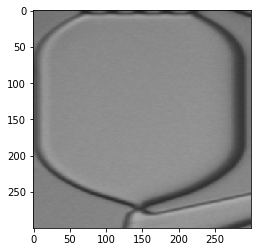

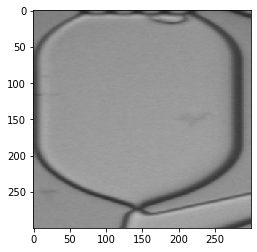

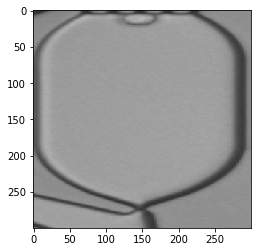

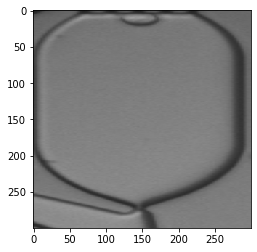

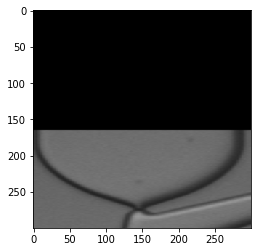

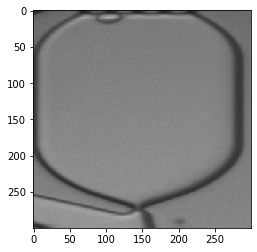

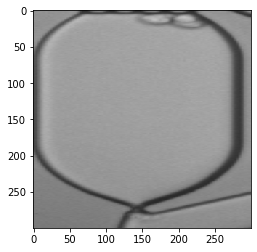

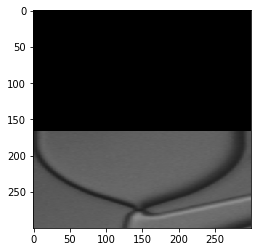

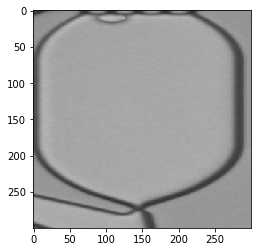

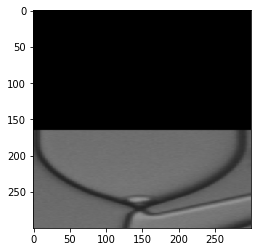

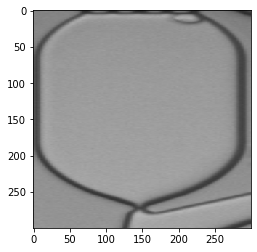

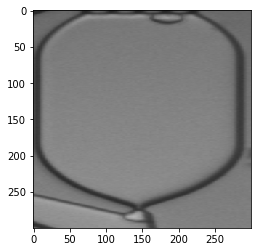

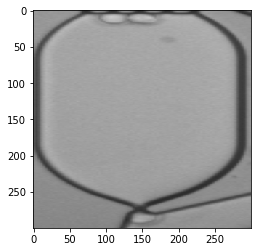

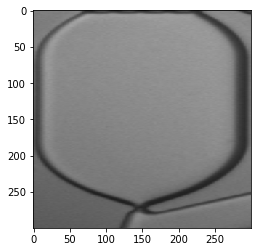

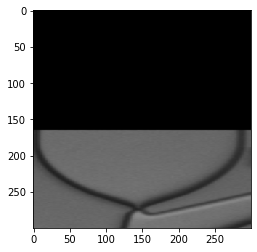

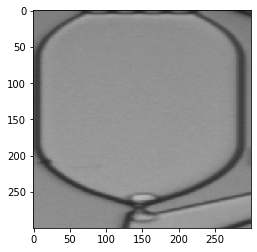

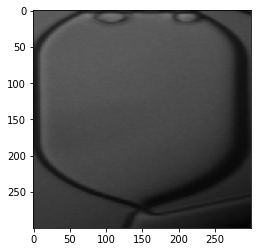

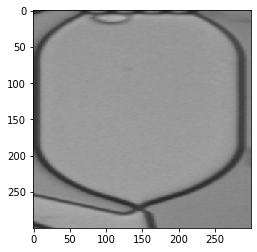

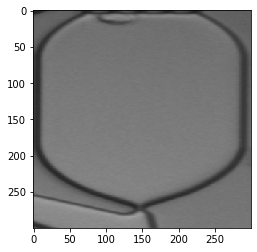

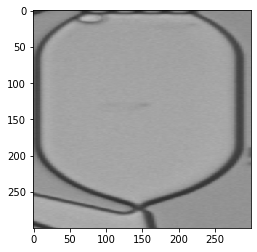

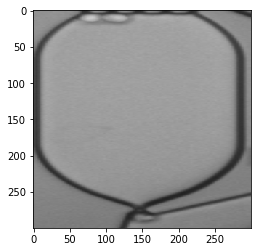

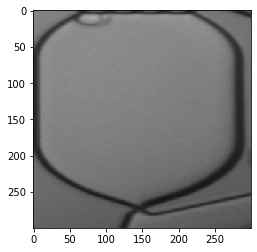

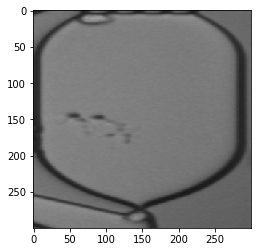

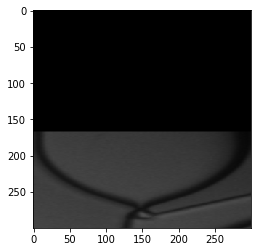

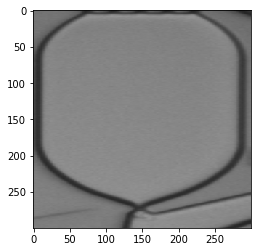

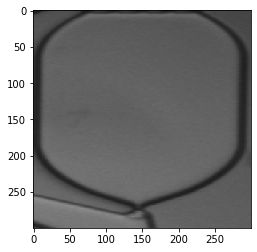

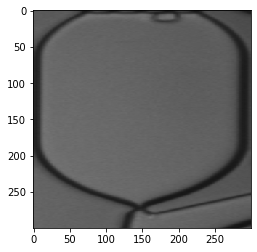

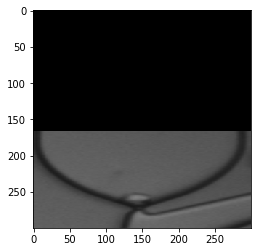

In [100]:
for im in imgs['img']:
    plt.figure()
    plt.imshow(cv2.resize(im, (300,300)))

In [102]:
def preprocess(img, template, thres=0.98):
    m = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)
    loc = np.where(m>thres)
    img_ = img.copy()
    h, w = template.shape[:2]
    dets = loc_to_dets(loc, m, w, h)
    dets = nms(dets, 0.5)
    print("Find "+str(len(dets))+" markers!")
    return cut_image(img, dets, (300, 200))

In [103]:
ans = preprocess(img, template)

Find 28 markers!


### Evaluate Model 

In [37]:
# Load Model
set_cfg('yolact_cell_config')
cudnn.fastest = True

torch.set_default_tensor_type('torch.cuda.FloatTensor')
net = Yolact()
net.load_weights('../weights/best_1.pth')
net.eval()
net.cuda()

Yolact(
  (backbone): ResNetBackbone(
    (layers): ModuleList(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, ker

In [15]:
def prep_display(dets_out, img, top_k=50, score_threshold=0.1, class_color=False, 
                 mask_alpha=0.45, display_mask=True, display_bboxes=True, display_text=False):
    img_gpu = img / 255.0
    h, w, _ = img.shape

    with timer.env('Postprocess'):
        t = postprocess(dets_out, w, h, visualize_lincomb = False,
                                        crop_masks        = False,
                                        score_threshold   = score_threshold )
        #torch.cuda.synchronize()

    with timer.env('Copy'):
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][:top_k]
        classes, scores, boxes = [x[:top_k].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)

        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]

        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        colors = torch.cat([get_color(j, on_gpu=None).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1

        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand

    if num_dets_to_consider == 0:
        return img_numpy

    if display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if display_bboxes:
                #cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)
                cv2.circle(img_numpy, (int(x1/2+x2/2), int(y1/2+y2/2)), 1, (0,0,255), 3)

            if display_text:
                _class = 'cell'
                #= cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if args.display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.3
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)


    return img_numpy

In [105]:
def prep_display(dets_out, img, h, w, undo_transform=True, class_color=False, mask_alpha=0.45,
                 top_k=50, score_threshold=0.1, display_masks=True, display_bboxes=True, display_text=False, display_scores=False):
    """
    Note: If undo_transform=False then im_h and im_w are allowed to be None.
    """
    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape

    with timer.env('Postprocess'):
        t = postprocess(dets_out, w, h, visualize_lincomb = False,
                                        crop_masks        = False,
                                        score_threshold   = score_threshold)
        torch.cuda.synchronize()

    with timer.env('Copy'):
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][:top_k]
        classes, scores, boxes = [x[:top_k].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        print(color_cache)
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)

        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]

        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1

        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand

    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if num_dets_to_consider == 0:
        return img_numpy

    if display_text or display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if display_bboxes:
                #cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)
                cv2.circle(img_numpy, (int(x1/2+x2/2), int(y1/2+y2/2)), 1, (0,0,255), 3)

            if display_text:
                _class = 'cell'
                #= cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.3
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)


    return img_numpy

In [106]:
def evalimage(net, img, save_path:str=None):
    frame = torch.from_numpy(img).cuda().float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    print(batch.shape)
    with torch.no_grad():
        preds = net(batch)

    img_numpy = prep_display(preds, frame, None, None, undo_transform=False, display_masks=False)

    if save_path is None:
        img_numpy = img_numpy[:, :, (2, 1, 0)]

    if save_path is None:
        plt.imshow(img_numpy)
        plt.show()
    else:
        cv2.imwrite(save_path, img_numpy)


In [107]:
def evalimages(net, imgs):
    for img in imgs:
        evalimage(net, img)

In [108]:
cfg.mask_proto_debug=False

torch.Size([1, 3, 300, 300])


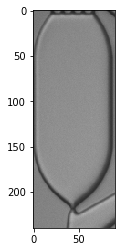

torch.Size([1, 3, 300, 300])


NameError: name 'color_cache' is not defined

In [109]:
evalimages(net, ans['img'])